In [762]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.transforms import Affine2D
import math
from matplotlib.patheffects import RendererBase
import seaborn as sns

In [234]:
def CalculateFontsize(xlim, ylim, ax, fig, rows, cols, unit_scale=1):
    # Get axis limits
    axXlim = ax.get_xlim()
    axYlim = ax.get_ylim()

    # Get figure dimensions in pixels
    fig_width, fig_height = fig.get_size_inches() * fig.dpi

    # Get axis dimensions in pixels
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width * fig.dpi, bbox.height * fig.dpi

    # Calculate font size proportional to axis units
    fontsize_x = unit_scale * ax_width / (axXlim[1] - axXlim[0]) / cols * (xlim[1] - xlim[0])
    fontsize_y = unit_scale * ax_height / (axYlim[1] - axYlim[0]) / rows * (ylim[1] - ylim[0])

    # Use the minimum of the two to keep the font size consistent
    fontsize = min(fontsize_x, fontsize_y)

    return fontsize

In [259]:
def GetStartEnd(msa, start, end):
    length = len(msa[0])
    if (start == None):
        start = 0
    elif (start < 0):
        start = length + start 
    if (end == None):
        end = length - 1 
    elif (end < 0):
        end = length + end 
    return start, end

In [273]:
def GetColorMap(msa, color_order = None, palette = None):
    color_map = {}
    if (color_order != None):
        for i,c in enumerate(color_order):
            color_map[c] = sns.color_palette(palette)[i]
            
    # The case some of the alphabet color is not specified in the order     
    for a in msa:
        for c in a:
            if c not in color_map:
                size = len(color_map)
                color_map[c] = sns.color_palette(palette)[size]
    return color_map

In [504]:
def DrawMSA(msa, seq_names = None, start = None, end = None,
            axlim = None, color_map = None, color_order = None, palette=None, ax=None, fig=None):
    # Get the canvas attributes.
    ax = ax or plt.gca()
    
    fig = fig or ax.get_figure()
    renderer = fig.canvas.get_renderer()
    
    height = len(msa)
    length = len(msa[0])
    
    # start, end: draw the [start,end] (both inclusive) region of the MSA
    start, end = GetStartEnd(msa, start, end)
    
    if (axlim == None):
        fontsize = CalculateFontsize(ax.get_xlim(), ax.get_ylim(), ax, fig, height, end - start + 1)
    else:
        fontsize = CalculateFontsize(axlim[0], axlim[1], ax, fig, height, end - start + 1)
    
    color_map = GetColorMap(msa, color_order, palette)
    
    lengthUnit = 1 / (end - start + 1)
    heightUnit = 1 / height 
    if (axlim != None):
        lengthUnit = (axlim[0][1] - axlim[0][0]) / (end - start + 1)
        heightUnit = (axlim[1][1] - axlim[1][0]) / height
    
    for i, a in enumerate(msa):
        for j,c in enumerate(a[start:end+1]):
            ax.text(x=(j + 0.5)*lengthUnit, y=(i+0.025) * heightUnit, s=c, color="black",
                va="baseline", ha="center", fontsize=fontsize,
                transform=ax.transAxes if axlim == None else ax.transData)
            ax.add_patch( patches.Rectangle(xy=(j * lengthUnit, i * heightUnit),
                                           width = lengthUnit, height=heightUnit,
                                          facecolor=color_map[c], linewidth=fontsize/50, edgecolor="white",
                                          transform=ax.transAxes if axlim == None else ax.transData))
    if (axlim == None):
        ax.set_xlim(-0.5, end - start + 1 - 0.5)
        ax.set_ylim(0, height)
        
        ticks = []
        tickLabels = []
        for i in range(start, end + 1):
            ticks.append(i - start)
            tickLabels.append(i)
        ax.set_xticks(ticks, tickLabels)
        
        ticks = []
        tickLabels = []
        for i in range(height):
            ticks.append(i)
            tickLabels.append(i if seq_names == None else seq_names[i])
        ax.set_yticks(ticks, tickLabels)
            
    return ax, color_map

In [288]:
def GetConsensus(msa, start = None, end = None):
    start, end = GetStartEnd(msa, start, end)
    consensus = []
    consensusComposition = []
    for j in range(start, end + 1):
        composition = {}
        for i,a in enumerate(msa):
            if (a[j] not in composition):
                composition[a[j]] = 0
            composition[a[j]] += 1
        result = ""
        maxCnt = 0
        for c in composition:
            if (composition[c] > maxCnt):
                maxCnt = composition[c]
                result = c
        consensus.append(result)
        consensusComposition.append(composition)
    return consensus, consensusComposition

In [745]:
def SetConsensusAxTicks(consensus, consensusComposition, ax):
    ticks = []
    tickLabels = []
    for i in range(len(consensus)):
        ticks.append(i)
        label = consensus[i]
        for c in consensusComposition[i]:
            if (c == label):
                continue
            if (consensusComposition[i][c] == consensusComposition[i][label]):
                label = 'X'
                break
        tickLabels.append(label)
    ax.set_xticks(ticks, tickLabels)

In [736]:
def DrawConsensusHisto(msa, color = [0, 0, 1], start = None, end = None, ax=None):
    ax = ax or plt.gca()
    consensus, consensusComposition = GetConsensus(msa, start, end)
    binHeight = []
    colors = []
    for i in range(len(consensus)):
        binHeight.append( consensusComposition[i][consensus[i]] / 
                         sum(consensusComposition[i].values()) )
        colors.append([1-binHeight[i], 1-binHeight[i], 1]) # color-base in blue
    ax.bar(x=list(range(0, len(consensus))), height=binHeight, 
           color = colors,
           width=0.95)
    ax.set(ylim=(0, 1))
    SetConsensusAxTicks(consensus, consensusComposition, ax)

In [760]:
# Code from pyseqlogo for scale font to one direction
class Scale(RendererBase):
    """Scale alphabets using affine transformation"""

    def __init__(self, sx, sy=None):
        self._sx = sx
        self._sy = sy

    def draw_path(self, renderer, gc, tpath, affine, rgbFace):
        affine = Affine2D().scale(self._sx, self._sy) + affine
        renderer.draw_path(gc, tpath, affine, rgbFace)

In [615]:
def CalculateEntropy(count):
    s = sum(count)
    return sum([-c/s * math.log2(c/s) for c in count])

In [752]:
def DrawSeqLogo(msa, color_map, alphabet_size, start = None, end = None, ax=None):
    ax = ax or plt.gca()
    fig = ax.get_figure()
    start, end = GetStartEnd(msa, start, end)
    
    consensus, consensusComposition = GetConsensus(msa, start, end)

    # Definition from https://en.wikipedia.org/wiki/Sequence_logo
    r = []
    adjuste = 1 / math.log(2) * (alphabet_size - 1) / (2 * len(msa[0]))
    for i,c in enumerate(consensus):
        entropy = CalculateEntropy(list(consensusComposition[i].values()))
        r.append(math.log2(alphabet_size) - (entropy + adjuste))
    
    ax.set_xlim(-0.5, end-start+1-0.5)
    ax.set_ylim(0, max(r))
    # Search for appropriate height. 
    
    fontsize = CalculateFontsize(ax.get_xlim(), ax.get_ylim(), 
                                 ax, fig, 1, end - start + 1)
    
    lengthUnit = 1
    for i,c in enumerate(consensusComposition):
        prevy = 0
        totalCount = sum(list(c.values()))
        for j,item in enumerate(sorted(c.items(), key=lambda x:x[1], reverse=True)):
            k = item[0]
            v = item[1]
            text = ax.text(x=i * lengthUnit, y=prevy, s=k, fontsize=fontsize,
               va="baseline", ha="center", color = color_map[k],
               transform=ax.transData)
            
            height = v / totalCount * r[i]
            tbox = text.get_window_extent(text._renderer).transformed(ax.transData.inverted())
            scale = height / (tbox.y1 - prevy) 
            #print(i, j, height, scale, tbox)
            prevy = prevy + height 
            text.set_path_effects([Scale(1.0, scale)])
    SetConsensusAxTicks(consensus, consensusComposition, ax)

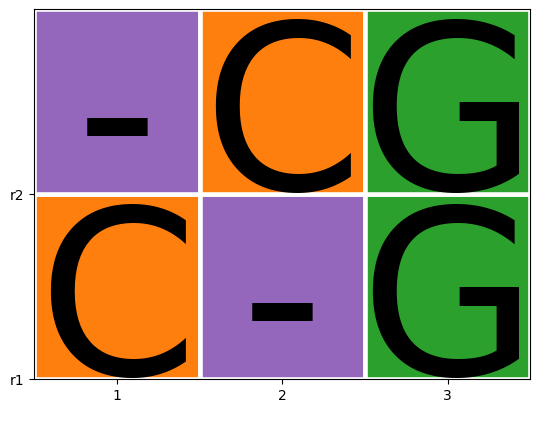

In [505]:
#ax = plt.gca()
#ax.set(xlim=[-20,20], ylim=[-20, 20])
ax, color_map=DrawMSA(msa=["AC-G-T", "A-CGT-"], seq_names = ["r1", "r2"],
           start = 1, end = 3, color_order="ACGT")

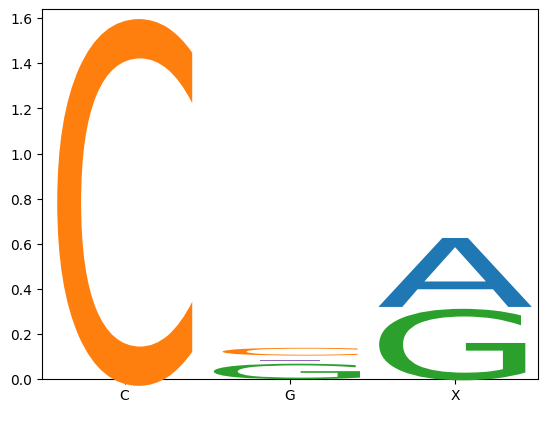

In [765]:
#ax = plt.gca()
#ax.set(xlim=[-20,20], ylim=[-20, 20])
DrawSeqLogo(["AC-G-T", "ACCGT-", "ACGAGT", "ACGAGT"], color_map, 4, start = 1, end = 3)

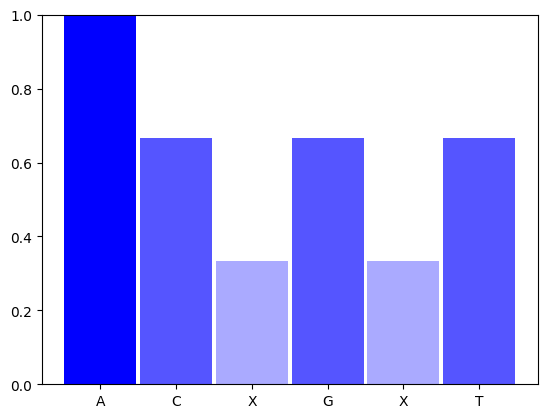

In [355]:
DrawConsensusHisto(msa=["AC-G-T", "A-CGT-", "ACGAGT"])

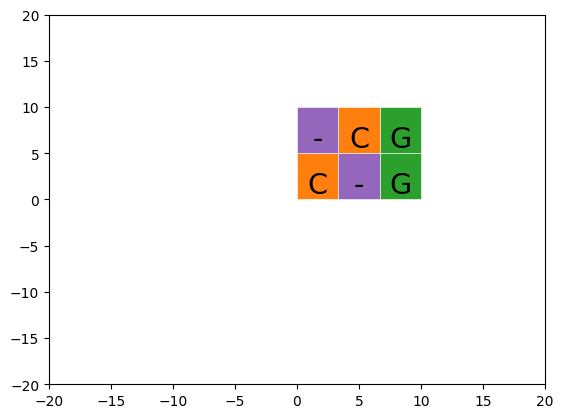

In [252]:
ax = plt.gca()
ax.set(xlim=[-20,20], ylim=[-20, 20])
ax=DrawMSA(msa=["AC-G-T", "A-CGT-"], color_order="ACGT-",
          axlim=[[0,10], [0,10]], start=1, end=3, ax=ax)

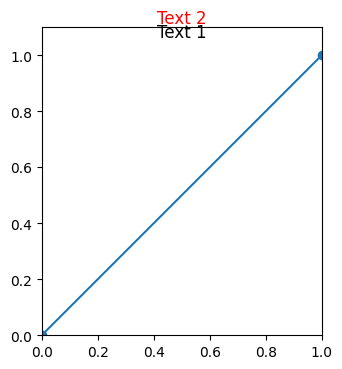

In [699]:
import matplotlib.pyplot as plt

# Create a simple plot
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], marker='o')  # Example data

# Define the position at the top of the y-axis
x_position = 0.5
y_position = 1.05  # You can adjust this based on your y limits

# Add the first text
plt.text(x_position, y_position, 'Text 1', fontsize=12, ha='center', va='bottom')

# Add the second text, also at the same position
plt.text(x_position, y_position + 0.05, 'Text 2', fontsize=12, ha='center', va='bottom', color='red')

# Set the limits for the y-axis
plt.ylim(0, 1.1)  # Ensure there's enough space for the text at the top

# Show the plot
plt.xlim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()